In [1]:
import sys 

import uproot
import awkward as ak
import numpy as np

sys.path.insert(0,"/eos/user/j/jstowell/Software/Analysis/hk-BONSAI/wcte_python_toolkit/python/")
import pyBONSAI

import pyWCTEAnalysisTools
from pyWCTEAnalysisTools import *

import ROOT 
import glob 
import numpy as np 
import pandas as pd 
import array
import pandas as pd
import os
import cppyy

pyBONSAI.set_default_directories(
    WCSIM_BUILD_DIR="/eos/user/j/jstowell/Software/WCSim/WCSim-develop/build4/",
    BONSAIDIR="/eos/user/j/jstowell/Software/Analysis/hk-BONSAI/wcte_python_toolkit/",
    BONSAIPARAM="updated_params.dat"
)
bonsai = pyBONSAI.WCTE_hkBONSAI()


BONSAI ENV
 - WCSIM_BUILD_DIR =  /eos/user/j/jstowell/Software/WCSim/WCSim-develop/build4/
 - BONSAIDIR =  /eos/user/j/jstowell/Software/Analysis/hk-BONSAI/wcte_python_toolkit/
 - BONSAIPARAM =  updated_params.dat
 Geometry Loading (NPMT=1995) 
Loaded 1995 PMT locations, maximum r=157.713089, maximum z=138.848557
reading updated_params.dat...
BONSAI and Clusfit Shared Parameters
-------------------------------------------------------
PMT time resolution:                           1.00 ns
PMT coincidence time difference:               1.00 ns
PMT pair maximal distance fraction:            0.1785
PMT pair maximal time difference fraction:     0.1079
Maximum # of hits to do all 4-hit combin.:    14
Initial grid constant:                       100.00 cm
Minimum wall distance for 4-hit vertices:     50.00 cm

Clusfit Parameters
-------------------------------------------------------
Clusfit grid constant:                       100.00 cm
Minimum wall distance for Clusfit vertex:     25.00 cm

In [54]:
cable_mapping_list = np.load("WCSIM_CABLE_MAP.npy")

class ReadoutWindow:
    def __init__(self):
        self.valid = False
        
def add_pmtindex(w):
    w.lookupids = w.hit_mpmt_slot_ids*100 + w.hit_pmt_channel_ids
    

def add_cables(w):
    w.cables = cable_mapping_list[w.lookupids].astype(np.int32)
    
def getwindows(chunk, branches):
    nwindows = len(chunk[branches[0]])
    
    hit_pmt_has_time_constant = chunk["hit_pmt_has_time_constant"]
    hit_pmt_calibrated_times = chunk["hit_pmt_calibrated_times"]
        
    rwlist= []
    for i in range(nwindows):
        rw = ReadoutWindow()
        
        mask = hit_pmt_has_time_constant[i] > 0
        order = ak.argsort( hit_pmt_calibrated_times[i][mask] )

        for attr in branches:            
            setattr(rw, attr, chunk[attr][i][mask][order])
                
        rw.valid = True
        add_pmtindex(rw)
        add_cables(rw)
        
        rwlist.append(rw)
        
    return rwlist


def window_builder(gen):
 
    branches=[
        "hit_pmt_calibrated_times",
        "hit_pmt_has_time_constant",
        "hit_pmt_charges",
        "hit_pmt_channel_ids",
        "hit_pmt_position_ids",
        "hit_mpmt_slot_ids",
        "hit_mpmt_card_ids",
        "hit_pmt_channel_ids",
        "hit_pmt_position_ids"
    ]
    
    for item in gen:
        windows = getwindows(item, branches)
        yield windows
        

def iterate_readout_windows(filename, step_size, max_size=None):
    
    branches=[
        "hit_pmt_calibrated_times",
        "hit_pmt_has_time_constant",
        "hit_pmt_charges",
        "hit_pmt_channel_ids",
        "hit_pmt_position_ids",
        "hit_mpmt_slot_ids",
        "hit_mpmt_card_ids",
        "hit_pmt_channel_ids",
        "hit_pmt_position_ids"
    ]

    chunks = uproot.iterate(f"{filename}:WCTEReadoutWindows", 
                            branches, 
                            library="np", 
                            step_size=step_size)
    
    count = 0
    for windows in window_builder(chunks):
        count += step_size
        if count > max_size: break
        yield windows
        


def iterate_n50_windows(w,
                    nhits_min=0,
                    nhits_max=10000):
    
    startidx = 0
    endidx = 0
    
    mask = w.cables > 0
    w.hit_pmt_calibrated_times = w.hit_pmt_calibrated_times[mask]
    w.hit_pmt_charges = w.hit_pmt_charges[mask]
    w.cables = w.cables[mask]
    
    hittimes = w.hit_pmt_calibrated_times
    nmax = len(hittimes)
      
    windows = []
    i = 0
    while i < nmax:
        
        startidx = i
        starttime = hittimes[startidx]
        
        for j in range(i,nmax-1):
            endidx = j
            endtime = hittimes[endidx+1]
        
            if (endtime - starttime) > 50:
                break
        i += 1
        
        nhits = (endidx - startidx)
        if nhits > nhits_min and nhits < nhits_max:
            rwn = ReadoutWindow()
            rwn.hit_pmt_calibrated_times = hittimes[startidx:endidx]
            rwn.hit_pmt_charges = w.hit_pmt_charges[startidx:endidx]
            rwn.cables = w.cables[startidx:endidx]
            
            # Remove duplicated hits, getting the first one seen (not ideal).
            _, unique_indices = np.unique(rwn.cables, return_index=True)
            unique_indices = np.sort(unique_indices)
            
            rwn.cables = rwn.cables[unique_indices]
            rwn.hit_pmt_charges = rwn.hit_pmt_charges[unique_indices]
            rwn.hit_pmt_calibrated_times = rwn.hit_pmt_calibrated_times[unique_indices]
            
            # Add aliases
            rwn.times = rwn.hit_pmt_calibrated_times
            rwn.charges = rwn.hit_pmt_charges
            
            yield rwn
            
            i = endidx
        

class BonsaiResult:
    def __init__(self):
        self.valid = False

def run_bonsai(n50window, apply_offset=True, likelihood_cut = 0.9):
    
    time_offset = 0
    if (apply_offset):
        time_offset = np.median(n50window.times) - 100
    
    bsVertex = array.array('f',3*[0.0])
    bsResult = array.array('f',6*[0.0])
    bsGood = array.array('f',3*[0.0])
    bsNsel = array.array('i',[0])
    bsNhit = array.array('i',[0])

    bsCAB_a = array.array('i', n50window.cables)
    bsT_a   = array.array('f', n50window.times - time_offset)
    bsQ_a  = array.array('f',  n50window.charges)
    bsNhit = array.array('i', [len(n50window.charges)])
    
    nhits = bonsai.BonsaiFit(bsVertex, bsResult, bsGood, bsNsel, bsNhit, bsCAB_a, bsT_a, bsQ_a);
           
    result = BonsaiResult()
    result.nhits_valid = nhits
    result.nhits = bsNhit[0]
    result.x = bsVertex[0]
    result.y = bsVertex[1]
    result.z = bsVertex[2]
    result.r0 = bsResult[0]
    result.r1 = bsResult[1]
    result.r2 = bsResult[2]
    result.r3 = bsResult[3]
    result.r4 = bsResult[4]
    result.r5 = bsResult[5]
    result.g0 = bsGood[0]
    result.g1 = bsGood[1]
    result.g2 = bsGood[2]
    result.likelihood = bsGood[1]
    
    if result.likelihood > likelihood_cut:
        result.valid = True
        
    return result


100%|██████████| 1000/1000 [00:00<00:00, 7675.94it/s]


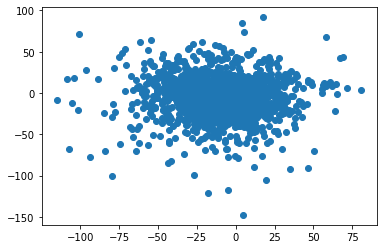

In [94]:

points = []
    
# Grab chunks of windows from file
# for readoutwindowstep in iterate_readout_windows("my_wcsim_hitfile.root",
#                                        step_size=1000, 
#                                        max_size=30000):
    
    
for readoutwindowstep in iterate_readout_windows(get_offline_run_base(1770),
                                       step_size=100, 
                                       max_size=300):
    
    # Grab the individual readout window
    for readoutwindow in tqdm(readoutwindowstep):
        
        # Iterate over n50 windows
        for n50window in iterate_n50_windows(readoutwindow,
                                             nhits_min=10,
                                             nhits_max=40000):
            
            result = run_bonsai(n50window)
            points.append(result)
            
            
df = pd.DataFrame([vars(p) for p in points]).select_dtypes(include=["number"])

plt.scatter( df.x, df.y )
plt.show()

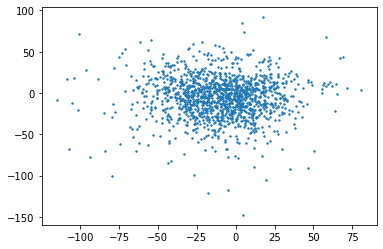

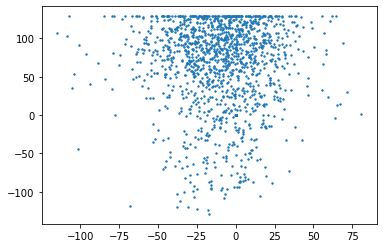

In [95]:
df = pd.DataFrame([vars(p) for p in points]).select_dtypes(include=["number"])

# df = df[df.likelihood > 0.5]

plt.scatter( df.x, df.y, s=2 )
plt.show()

plt.scatter( df.x, df.z, s=2 )
plt.show()

In [89]:

#1766 - NiCf in blackbox. Background run
#1767 - (0,0,0)
#1768 - 0,0,0)
#1769 - (135,0,0)
#1770 - (135, 55, 99)
#1771 - (135, 0, 193)
